In [ ]:
# Citation Prediction Solution

# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
import nltk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources (only need to run this once)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

In [5]:
# Cell 2: Define utility functions
def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = nltk.stem.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

def author_overlap(authors_1, authors_2):
    """Compute Jaccard similarity between author sets"""
    if not authors_1 or not authors_2:
        return 0
    set1 = set(authors_1)
    set2 = set(authors_2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def common_neighbors(graph, node1, node2):
    """Count the number of common neighbors in a directed graph"""
    if node1 not in graph or node2 not in graph:
        return 0
    # Get all neighbors (both predecessors and successors)
    neighbors1 = set(graph.predecessors(node1)).union(set(graph.successors(node1)))
    neighbors2 = set(graph.predecessors(node2)).union(set(graph.successors(node2)))
    
    # Count common neighbors
    return len(neighbors1.intersection(neighbors2))

def adamic_adar_index(graph, node1, node2):
    """Compute the Adamic-Adar index for a pair of nodes"""
    if node1 not in graph or node2 not in graph:
        return 0
    
    # Get all neighbors (both predecessors and successors)
    neighbors1 = set(graph.predecessors(node1)).union(set(graph.successors(node1)))
    neighbors2 = set(graph.predecessors(node2)).union(set(graph.successors(node2)))
    common = neighbors1.intersection(neighbors2)
    
    # Calculate the Adamic-Adar index
    score = 0
    for neighbor in common:
        # Get the total degree (in + out) of the neighbor
        degree = graph.in_degree(neighbor) + graph.out_degree(neighbor)
        if degree > 1:  # Avoid log(1) which is 0
            score += 1 / np.log(degree)
    return score


##### <h4 style="color:red;">Pipeline Step 0 : Textual Data </h4>#####

Σε αυτο το βημα θα προσπαθησουμε να διαβασουμε τα αρχεια abstracts.txt ,authors.txt' ,edgelist.txt ,test.txt




In [14]:
# Cell 3: Load data
print("Loading data...")
start_time = time.time()

with open('abstracts.txt', 'r', encoding='utf-8') as file:
    abstracts_raw = file.readlines()

with open('authors.txt', 'r', encoding='utf-8') as file:
    authors_raw = file.readlines()

with open('edgelist.txt', 'r', encoding='utf-8') as file:
    edges_raw = file.readlines()

with open('test.txt', 'r', encoding='utf-8') as file:
    test_raw = file.readlines()

# Parse abstracts
abstracts = {}
for line in abstracts_raw:
    parts = line.strip().split('|--|')
    if len(parts) == 2:
        paper_id, abstract = parts
        abstracts[int(paper_id)] = abstract

# Parse authors
authors = {}
for line in authors_raw:
    parts = line.strip().split('|--|')
    if len(parts) == 2:
        paper_id, author_list = parts
        # Split the author list by commas
        author_names = author_list.split(',')
        authors[int(paper_id)] = author_names

# Create graph from edgelist
edges = []
for line in edges_raw:
    source, target = line.strip().split(',')
    edges.append((int(source), int(target)))

# Parse test pairs
test_pairs = []
for line in test_raw:
    source, target = line.strip().split(',')
    test_pairs.append((int(source), int(target)))

print(f"Data loaded in {time.time() - start_time:.2f} seconds")


Loading data...
Data loaded in 3.25 seconds


<h4 style="color:red;"><b>Δημιουργία Κατευθυνόμενου Γράφου</b></h4>

Σε αυτό το βήμα δημιουργούμε έναν κατευθυνόμενο γράφο με τα κείμενα των abstracts των papers ως κόμβους και τη σύνδεση που έχουν το ένα με το άλλο σαν ακμή.

Σημαντικά δεδομένα που μπορούμε να εξάγουμε κατά την υλοποίηση αυτού του βήματος είναι:

1. Πόσοι κόμβοι (papers) και πόσες ακμές (αναφορές) υπάρχουν συνολικά

2. Μέσος όρος in-degree = Πόσες φορές κατά μέσο όρο αναφέρεται ένα paper

3. Μέσος όρος out-degree = Πόσα papers αναφέρει ένα paper κατά μέσο όρο

4. Πυκνότητα γράφου (graph density) = Πόσο "γεμάτος" είναι ο γράφος σε σχέση με τον μέγιστο αριθμό δυνατών ακμών

5. PageRank = Ένας δείκτης που μετρά τη "σημασία" ενός paper στο δίκτυο των αναφορών.  
   Ο PageRank δεν βασίζεται μόνο στον αριθμό των αναφορών που λαμβάνει ένα paper (in-degree), αλλά λαμβάνει υπόψη του και τη σημαντικότητα αυτών που το αναφέρουν. Έτσι, ένα paper που αναφέρεται από άλλα σημαντικά papers αποκτά υψηλότερο PageRank.  
   Με τη βοήθεια του PageRank μπορούμε να εντοπίσουμε ποια papers έχουν τη μεγαλύτερη επιρροή στο γράφο και άρα ίσως τη μεγαλύτερη σημασία .


Creating graph and analyzing data...
Graph created with 138499 nodes and 1091955 edges
Average in-degree: 7.88
Average out-degree: 7.88
Graph density: 0.000057

Top 10 papers by PageRank:
Paper ID: 107231, PageRank Score: 0.00013
Paper ID: 43621, PageRank Score: 0.00012
Paper ID: 48937, PageRank Score: 0.00012
Paper ID: 27207, PageRank Score: 0.00011
Paper ID: 96240, PageRank Score: 0.00011
Paper ID: 40173, PageRank Score: 0.00010
Paper ID: 83167, PageRank Score: 0.00010
Paper ID: 134917, PageRank Score: 0.00009
Paper ID: 24536, PageRank Score: 0.00009
Paper ID: 19262, PageRank Score: 0.00009

PageRank Stats:
Mean: 0.000007
Median: 0.000005
Max: 0.000132
Min: 0.000003
PageRank scores saved to 'pagerank_scores.csv'


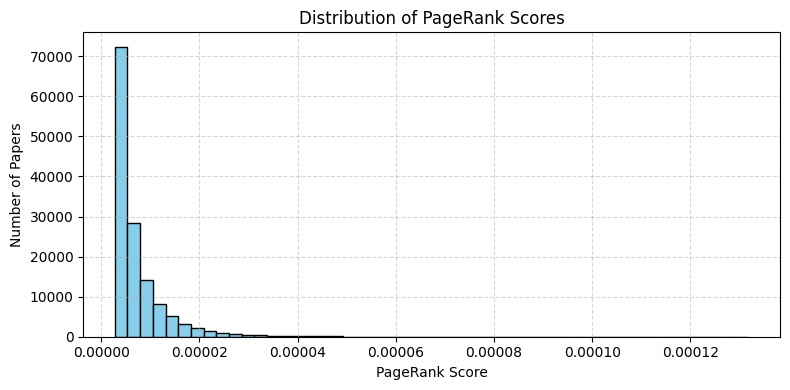

Graph analysis completed in 6.14 seconds


In [15]:
# Cell 4: Create graph and analyze data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Creating graph and analyzing data...")
start_time = time.time()

# Create a directed graph
G = nx.DiGraph()

# Add all papers as nodes (including those without edges)
all_papers = set(list(abstracts.keys()))
G.add_nodes_from(all_papers)

# Add edges
G.add_edges_from(edges)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Basic graph analysis (quick stats)
avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
avg_out_degree = sum(dict(G.out_degree()).values()) / G.number_of_nodes()

print(f"Average in-degree: {avg_in_degree:.2f}")
print(f"Average out-degree: {avg_out_degree:.2f}")

# Analyze graph density
density = nx.density(G)
print(f"Graph density: {density:.6f}")

# Compute PageRank
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

# Print top 10 papers by PageRank
top_papers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 papers by PageRank:")
for pid, score in top_papers:
    print(f"Paper ID: {pid}, PageRank Score: {score:.5f}")

# Compute and print PageRank statistics
scores = list(pagerank.values())
print(f"\nPageRank Stats:")
print(f"Mean: {np.mean(scores):.6f}")
print(f"Median: {np.median(scores):.6f}")
print(f"Max: {np.max(scores):.6f}")
print(f"Min: {np.min(scores):.6f}")

# Optional: Save PageRank scores to CSV
df_pagerank = pd.DataFrame([
    {'paper_id': pid, 'pagerank': score}
    for pid, score in pagerank.items()
])
df_pagerank.sort_values(by='pagerank', ascending=False).to_csv("pagerank_scores.csv", index=False)
print("PageRank scores saved to 'pagerank_scores.csv'")

# Optional: Visualize PageRank distribution
plt.figure(figsize=(8, 4))
plt.hist(scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of PageRank Scores")
plt.xlabel("PageRank Score")
plt.ylabel("Number of Papers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Graph analysis completed in {time.time() - start_time:.2f} seconds")


##### <h4 style="color:red;">Pipeline Step 1 : Preprocessing Data #####</h4>

Χρησιμοποιουμε μια συναρτηση preprocess_text() η οποια ειναι βασικη ωστε να αφαιρεσουμε stopwords (πχ . , ! ) και common english word ( and , or the ) . Στη συνεχεια χρησιμοποιουμε των αλγοριθμο tf-idf ωστε να εξαγουμε πληροφορια για το ποιες λεξεις ειναι σημαντικες σε καθε κειμενο απο τα abstracts και ποιες οχι βασικες συναρτησεις ειναι TfidfVectorizer() . Δημιουργουμε για επαληθευση ενα αρχειο csv για την κανοηση του tf_idf


In [ ]:
import pandas as pd

print("Processing abstracts and creating TF-IDF vectors...")
start_time = time.time()

# Preprocess abstracts
preprocessed_abstracts = {paper_id: preprocess_text(abstract) for paper_id, abstract in abstracts.items()}

# Create TF-IDF vectors for abstracts (limiting to 1000 features for efficiency)
vectorizer = TfidfVectorizer(max_features=3000)
paper_ids = list(preprocessed_abstracts.keys())
abstracts_text = [preprocessed_abstracts[paper_id] for paper_id in paper_ids]
tfidf_matrix = vectorizer.fit_transform(abstracts_text)

# Create a mapping from paper_id to index in the TF-IDF matrix
paper_id_to_index = {paper_id: i for i, paper_id in enumerate(paper_ids)}

# Save TF-IDF results to CSV
feature_names = vectorizer.get_feature_names_out()
tfidf_dense = tfidf_matrix.todense()

top_n = 10  # Number of top TF-IDF terms to keep
rows = []

for idx, paper_id in enumerate(paper_ids):
    tfidf_scores = list(zip(feature_names, tfidf_dense[idx].tolist()[0]))
    sorted_terms = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    top_terms_str = "; ".join([f"{term}:{score:.2f}" for term, score in sorted_terms if score > 0])
    
    rows.append({
        'paper_id': paper_id,
        'preprocessed_abstract': preprocessed_abstracts[paper_id],
        'top_tfidf_terms': top_terms_str
    })

df = pd.DataFrame(rows)
df.to_csv("abstracts_tfidf_summary.csv", index=False, encoding='utf-8')

print("TF-IDF summary exported to 'abstracts_tfidf_summary.csv'")

# Function to compute abstract similarity with memoization (unchanged)
abstract_sim_cache = {}
def abstract_similarity(paper1_id, paper2_id):
    """Compute cosine similarity between paper abstracts with caching"""
    cache_key = (min(paper1_id, paper2_id), max(paper1_id, paper2_id))
    if cache_key in abstract_sim_cache:
        return abstract_sim_cache[cache_key]

    if paper1_id not in paper_id_to_index or paper2_id not in paper_id_to_index:
        abstract_sim_cache[cache_key] = 0
        return 0

    i = paper_id_to_index[paper1_id]
    j = paper_id_to_index[paper2_id]
    sim = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix[j:j+1])[0][0]
    
    abstract_sim_cache[cache_key] = sim
    return sim

print(f"Abstract processing completed in {time.time() - start_time:.2f} seconds")


Processing abstracts and creating TF-IDF vectors...
TF-IDF summary exported to 'abstracts_tfidf_summary.csv'
Abstract processing completed in 390.75 seconds


In [ ]:
print("Computing network features...")
start_time = time.time()

# Compute basic centrality measures (these don't take too long)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)


# Create caches for network metrics to avoid recomputation
common_neighbors_cache = {}
adamic_adar_cache = {}

print(f"Network features computation completed in {time.time() - start_time:.2f} seconds")


Computing network features...
Network features computation completed in 1.90 seconds


<h4 style="color:red;"><b>ΔΗΜΙΟΥΡΓΙΑ ΑΡΝΗΤΙΚΩΝ ΠΑΡΑΔΕΙΓΜΑΤΩΝ</b></h4>

Παρακάτω φαίνεται το κομμάτι κώδικα που δημιουργεί τα δεδομένα εκπαίδευσης με θετικά και ίσα αρνητικά παραδείγματα :

<p style="color:green; "> θετικα παραδειγματα με label -> 1</p>

<p style="color:yellow; "> αρνητικα κα παραδειγματα με label -> 0</p>



In [16]:
# Cell 7: Generate training data
print("Generating training data...")
start_time = time.time()

# Positive examples: existing edges
positive_examples = edges

# Generate negative examples: pairs of nodes that are not connected
def generate_negative_examples(graph, n_samples, seed=42):
    """Generate random node pairs that are not connected in the graph"""
    np.random.seed(seed)
    nodes = list(graph.nodes())
    negative_examples = []
    
    while len(negative_examples) < n_samples:
        # Randomly select two nodes
        i, j = np.random.choice(nodes, 2, replace=False)
        
        # Check if there's no edge from i to j
        if not graph.has_edge(i, j):
            negative_examples.append((i, j))
    
    return negative_examples

# Create an equal number of negative examples as positive examples
negative_examples = generate_negative_examples(G, len(positive_examples))

# Combine positive and negative examples
all_examples = positive_examples + negative_examples
labels = [1] * len(positive_examples) + [0] * len(negative_examples)

print(f"Training data generation completed in {time.time() - start_time:.2f} seconds")
print(f"Number of positive examples: {len(positive_examples)}")
print(f"Number of negative examples: {len(negative_examples)}")

Generating training data...
Training data generation completed in 16820.26 seconds
Number of positive examples: 1091955
Number of negative examples: 1091955


<h4 style="color:red;"><b>Extract Features</b></h4>

1. Text similarity
abs_sim = abstract_similarity(source, target)

Υπολογίζει τη συνομοιότητα περιλήψεων (abstracts) των δύο papers.

abs_sim ** 2: Προσθέτει μη γραμμικό όρο (για να ενισχύσει μεγάλες τιμές).

2. Author features
auth_overlap: Αριθμός κοινού συγγραφέα.

auth_exact_match: 1 αν έχουν έστω έναν ίδιο συγγραφέα, αλλιώς 0.

abs_sim * auth_overlap: Συνδυαστικό χαρακτηριστικό (πόσο μοιάζουν και έχουν και ίδιους συγγραφείς).

3. Node-level features
Ανά κόμβο, υπολογίζει:

In-degree, Out-degree, Total degree

Log(in_degree), Log(out_degree): Για αποφυγή skewness (μεγάλα νούμερα).

Κεντρικότητες: In-degree, Out-degree, PageRank.

Για κάθε κόμβο (source & target), υπολογίζονται τα παραπάνω.

Συνδυαστικά:

Ratio: Πόσο μεγαλύτερος/μικρότερος είναι ο ένας από τον άλλον.

Difference: Απόλυτη και κανονικοποιημένη διαφορά στο degree.

4. Pair-level network features
Χαρακτηρίζουν τη σχέση των δύο κόμβων μέσα στον γράφο.

common_neighbors: Πόσοι κοινοί γείτονες έχουν.

adamic_adar: Μετρά πόσο "σπάνιοι" είναι οι κοινοί γείτονες (βάζει μικρότερη αξία σε πολύ συνδεδεμένους).

jaccard: Πόσο μοιάζουν οι γείτονες (intersection/union).

resource_alloc: Ανάποδο του degree των κοινών γειτόνων.

preferential_attachment: Προϊόν των degrees (πόσο πιθανή είναι η σύνδεση λόγω "δημοτικότητας").

citation_pattern: Ομοιότητα στα papers που αυτοί παραπέμπουν.

co-citation: Ομοιότητα στα papers που τους παραπέμπουν.

5. Combined Features

Συνδυάζει υπάρχοντα χαρακτηριστικά για πιο σύνθετα patterns:

pagerank_product: Σημασία των κόμβων στον γράφο.

abs_sim * common_neigh, abs_sim * adamic_adar: Συνδυασμός κειμενικής και δικτυακής πληροφορίας.

auth_overlap * common_neigh: Κοινή συγγραφική και γειτονική σχέση.

pref_attach / total_degree_sum: Κανονικοποιημένη "δημοτικότητα".

6. Direction-based features

Βασίζονται στη κατευθυντικότητα του γράφου:

Similarity in successors (outgoing links): πόσο μοιάζουν στους κόμβους που αναφέρουν.

Similarity in predecessors (incoming links): πόσο μοιάζουν στους κόμβους που τους αναφέρουν.

In [17]:
# Cell 8: Extract features efficiently (FIXED)
print("Extracting features...")
start_time = time.time()

def extract_features(graph, node_pairs, authors_dict):
    """Extract features for node pairs, optimized for speed"""
    features = []
    
    # Instead of using tqdm, just print progress manually
    total_pairs = len(node_pairs)
    print(f"Processing {total_pairs} node pairs...")
    
    for i, (source, target) in enumerate(node_pairs):
        # Initialize feature vector
        feature_vector = []
        
        # 1. Text similarity (abstract similarity)
        abs_sim = abstract_similarity(source, target)
        feature_vector.append(abs_sim)
        # Add squared term to capture non-linear relationships
        feature_vector.append(abs_sim ** 2)
        
        # 2. Author-based features
        auth_overlap = 0
        auth_exact_match = 0
        if source in authors_dict and target in authors_dict:
            auth_overlap = author_overlap(authors_dict[source], authors_dict[target])
            # Add author exact match feature
            auth_exact_match = 0
            for author in authors_dict[source]:
                if author in authors_dict[target]:
                    auth_exact_match = 1
                    break
        feature_vector.append(auth_overlap)
        feature_vector.append(auth_exact_match)
        # Add interaction term between text similarity and author overlap
        feature_vector.append(abs_sim * auth_overlap)
        
        # 3. Node-level features (in-degree, out-degree, pagerank)
        # Source features
        source_in_degree = in_degree.get(source, 0)
        source_out_degree = out_degree.get(source, 0)
        source_total_degree = source_in_degree + source_out_degree
        
        feature_vector.append(source_in_degree)
        feature_vector.append(source_out_degree)
        feature_vector.append(source_total_degree)
        feature_vector.append(np.log1p(source_in_degree))  # Log transform to handle skewed distributions
        feature_vector.append(np.log1p(source_out_degree))
        feature_vector.append(in_degree_centrality.get(source, 0))
        feature_vector.append(out_degree_centrality.get(source, 0))
        feature_vector.append(pagerank.get(source, 0))
        
        # Target features
        target_in_degree = in_degree.get(target, 0)
        target_out_degree = out_degree.get(target, 0)
        target_total_degree = target_in_degree + target_out_degree
        
        feature_vector.append(target_in_degree)
        feature_vector.append(target_out_degree)
        feature_vector.append(target_total_degree)
        feature_vector.append(np.log1p(target_in_degree))
        feature_vector.append(np.log1p(target_out_degree))
        feature_vector.append(in_degree_centrality.get(target, 0))
        feature_vector.append(out_degree_centrality.get(target, 0))
        feature_vector.append(pagerank.get(target, 0))
        
        # Degree ratio (to capture relative importance)
        if target_total_degree > 0:
            feature_vector.append(source_total_degree / target_total_degree)
        else:
            feature_vector.append(0)
            
        if source_total_degree > 0:
            feature_vector.append(target_total_degree / source_total_degree)
        else:
            feature_vector.append(0)
        
        # Degree difference (absolute and normalized)
        degree_diff = abs(source_total_degree - target_total_degree)
        feature_vector.append(degree_diff)
        
        if (source_total_degree + target_total_degree) > 0:
            norm_diff = degree_diff / (source_total_degree + target_total_degree)
            feature_vector.append(norm_diff)
        else:
            feature_vector.append(0)
        
        # 4. Pair-level network features
        # Common neighbors (with caching)
        cache_key = (min(source, target), max(source, target))
        if cache_key not in common_neighbors_cache:
            common_neighbors_cache[cache_key] = common_neighbors(graph, source, target)
        common_neigh = common_neighbors_cache[cache_key]
        feature_vector.append(common_neigh)
        feature_vector.append(np.log1p(common_neigh))  # Log transform for skewed distribution
        
        # Adamic-Adar index (with caching)
        if cache_key not in adamic_adar_cache:
            adamic_adar_cache[cache_key] = adamic_adar_index(graph, source, target)
        adamic_adar = adamic_adar_cache[cache_key]
        feature_vector.append(adamic_adar)
        
        # Jaccard coefficient
        # Calculate Jaccard coefficient separately to avoid caching issues
        jaccard = 0
        if source in graph and target in graph:
            neighbors1 = set(graph.predecessors(source)).union(set(graph.successors(source)))
            neighbors2 = set(graph.predecessors(target)).union(set(graph.successors(target)))
            
            if neighbors1 and neighbors2:
                intersection = len(neighbors1.intersection(neighbors2))
                union = len(neighbors1.union(neighbors2))
                jaccard = intersection / union if union > 0 else 0
        feature_vector.append(jaccard)
        
        # Resource allocation index
        # Calculate Resource Allocation separately
        resource_alloc = 0
        if source in graph and target in graph:
            neighbors1 = set(graph.predecessors(source)).union(set(graph.successors(source)))
            neighbors2 = set(graph.predecessors(target)).union(set(graph.successors(target)))
            common = neighbors1.intersection(neighbors2)
            
            for neighbor in common:
                degree = graph.in_degree(neighbor) + graph.out_degree(neighbor)
                if degree > 0:
                    resource_alloc += 1 / degree
        feature_vector.append(resource_alloc)
        
        # Preferential attachment
        pref_attach = source_total_degree * target_total_degree
        feature_vector.append(pref_attach)
        feature_vector.append(np.log1p(pref_attach))  # Log transform
        
        # Citation pattern similarity
        citation_pattern = 0
        if source in graph and target in graph:
            cited_by_source = set(graph.successors(source))
            cited_by_target = set(graph.successors(target))
            
            if cited_by_source and cited_by_target:
                intersection = len(cited_by_source.intersection(cited_by_target))
                union = len(cited_by_source.union(cited_by_target))
                citation_pattern = intersection / union if union > 0 else 0
        feature_vector.append(citation_pattern)
        
        # Co-citation similarity
        cocitation = 0
        if source in graph and target in graph:
            citing_source = set(graph.predecessors(source))
            citing_target = set(graph.predecessors(target))
            
            if citing_source and citing_target:
                intersection = len(citing_source.intersection(citing_target))
                union = len(citing_source.union(citing_target))
                cocitation = intersection / union if union > 0 else 0
        feature_vector.append(cocitation)
        
        # 5. Combined/Interaction features
        # PageRank product (captures importance of both nodes)
        pagerank_product = pagerank.get(source, 0) * pagerank.get(target, 0)
        feature_vector.append(pagerank_product)
        
        # Combine text similarity with network features
        feature_vector.append(abs_sim * common_neigh)
        feature_vector.append(abs_sim * adamic_adar)
        
        # Combine author overlap with network features
        feature_vector.append(auth_overlap * common_neigh)
        
        # Preferential attachment normalized by degree
        total_degree_sum = source_total_degree + target_total_degree
        if total_degree_sum > 0:
            feature_vector.append(pref_attach / total_degree_sum)
        else:
            feature_vector.append(0)
        
        # Direction-specific features
        # Successors similarity (outgoing links)
        source_successors = set(graph.successors(source)) if source in graph else set()
        target_successors = set(graph.successors(target)) if target in graph else set()
        
        if source_successors and target_successors:
            intersection = len(source_successors.intersection(target_successors))
            union = len(source_successors.union(target_successors))
            feature_vector.append(intersection / union if union > 0 else 0)
        else:
            feature_vector.append(0)
            
        # Predecessors similarity (incoming links)
        source_predecessors = set(graph.predecessors(source)) if source in graph else set()
        target_predecessors = set(graph.predecessors(target)) if target in graph else set()
        
        if source_predecessors and target_predecessors:
            intersection = len(source_predecessors.intersection(target_predecessors))
            union = len(source_predecessors.union(target_predecessors))
            feature_vector.append(intersection / union if union > 0 else 0)
        else:
            feature_vector.append(0)
        
        features.append(feature_vector)
        
        # Print progress every 10%
        if (i + 1) % max(1, total_pairs // 10) == 0:
            progress = (i + 1) / total_pairs * 100
            print(f"Progress: {progress:.1f}% ({i+1}/{total_pairs})")
    
    # Convert to numpy array
    features_array = np.array(features)
    
    print(f"Created {features_array.shape[1]} features per node pair")
    return features_array

# Extract features for training data
X = extract_features(G, all_examples, authors)
y = np.array(labels)

print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
print(f"Feature matrix shape: {X.shape}")

# Quick analysis of the features
print("\nFeature statistics:")
feature_means = np.mean(X, axis=0)
feature_stds = np.std(X, axis=0)
feature_mins = np.min(X, axis=0)
feature_maxs = np.max(X, axis=0)

print(f"Mean range: {np.min(feature_means):.4f} to {np.max(feature_means):.4f}")
print(f"Std range: {np.min(feature_stds):.4f} to {np.max(feature_stds):.4f}")
print(f"Min value: {np.min(feature_mins):.4f}")
print(f"Max value: {np.max(feature_maxs):.4f}")

Extracting features...
Processing 2183910 node pairs...
Progress: 10.0% (218391/2183910)
Progress: 20.0% (436782/2183910)
Progress: 30.0% (655173/2183910)
Progress: 40.0% (873564/2183910)
Progress: 50.0% (1091955/2183910)
Progress: 60.0% (1310346/2183910)
Progress: 70.0% (1528737/2183910)
Progress: 80.0% (1747128/2183910)
Progress: 90.0% (1965519/2183910)
Progress: 100.0% (2183910/2183910)
Created 41 features per node pair
Feature extraction completed in 2007.68 seconds
Feature matrix shape: (2183910, 41)

Feature statistics:
Mean range: 0.0000 to 2765.9472
Std range: 0.0000 to 17209.4177
Min value: 0.0000
Max value: 5114308.0000


<h4 style="color:red;"><b>Model Learning</b></h4>

Ο διαχωρισμός(split) εξυπηρετεί στον έλεγχο του μοντέλου σε δεδομένα που δεν έχει ξαναδεί. Έτσι, μπορούμε να εκτιμήσουμε την ικανότητά του να γενικεύει σε νέα δείγματα. 

Εκπαίδευση και Αξιολόγηση :

Εκπαίδευση στο X_train, y_train 80% των δειγμάτων

Πρόβλεψη πιθανοτήτων στο X_val 20% των δειγμάτων

stratify = Εξασφαλίζει ότι η αναλογία των κλάσεων (0 και 1) θα διατηρηθεί και στα δύο σύνολα (training & validation).

Υπολογισμός Log Loss και AUC (Area Under the Curve) 

Τα μοντελα που χρησιμοποιηθηκαν ειναι τα εξης:

1. Logistic Regression
- **Τύπος**: Γραμμικό μοντέλο ταξινόμησης (Linear Classifier)
- **Ιδανικό για**: Γρήγορη εκτίμηση, γραμμικά διαχωρίσιμα δεδομένα.
- **Πώς λειτουργεί**:
  - Υπολογίζει την πιθανότητα ένα δείγμα να ανήκει σε μια κατηγορία χρησιμοποιώντας τη λογιστική (sigmoid) συνάρτηση.
  - Απόφαση βασίζεται σε κατώφλι (π.χ. 0.5).
- **Πλεονεκτήματα**:
  - Γρήγορο στην εκπαίδευση.
  - Ερμηνεύσιμο: μπορείς να δεις τη βαρύτητα (weights) κάθε χαρακτηριστικού.
- **Περιορισμοί**:
  - Δεν αποδίδει καλά σε πολύπλοκα ή μη γραμμικά προβλήματα.


2. Random Forest
- **Τύπος**: Ensemble μοντέλο βασισμένο σε δέντρα απόφασης (Decision Trees)
- **Ιδανικό για**: Πολλά χαρακτηριστικά, μη γραμμικά δεδομένα.
- **Πώς λειτουργεί**:
  - Δημιουργεί πολλαπλά δέντρα (n_estimators) από τυχαία δείγματα και χαρακτηριστικά.
  - Συνδυάζει τις προβλέψεις των δέντρων με **ψηφοφορία** (classification) ή **μέσο όρο** (regression).
- **Πλεονεκτήματα**:
  - Ανθεκτικό σε υπερεκπαίδευση (overfitting).
  - Αντιμετωπίζει μη γραμμικές σχέσεις.
  - Δείχνει σημασία χαρακτηριστικών (feature importance).
- **Περιορισμοί**:
  - Πιο βαρύ υπολογιστικά.
  - Δυσκολότερο να ερμηνευθεί σε βάθος.



3. Gradient Boosting
- **Τύπος**: Ensemble boosting μοντέλο (ακολουθιακή εκπαίδευση δέντρων)
- **Ιδανικό για**: Υψηλή ακρίβεια, πολύπλοκα προβλήματα.
- **Πώς λειτουργεί**:
  - Εκπαιδεύει κάθε νέο δέντρο ώστε να διορθώσει τα λάθη του προηγούμενου.
  - Χτίζει μοντέλα διαδοχικά με στόχο την ελαχιστοποίηση της απώλειας (loss function).
- **Πλεονεκτήματα**:
  - Πολύ αποδοτικό για δεδομένα με θόρυβο ή περίπλοκες σχέσεις.
  - Συχνά υπερέχει σε AUC/accuracy.
- **Περιορισμοί**:
  - Αργή εκπαίδευση σε μεγάλα σύνολα.
  - Πιο ευαίσθητο σε υπερεκπαίδευση (αλλά υπάρχει τρόπος ελέγχου με παραμέτρους).






Feature Importance:
                         Feature  Importance
20               Target PageRank   21.436245
11  Source Out-Degree Centrality   13.610759
9         Log(Source Out-Degree)   12.909980
6              Source Out-Degree   10.818868
12               Source PageRank    7.444689
27             Adamic-Adar Index    4.848360
29     Resource Allocation Index    4.782058
28           Jaccard Coefficient    3.184542
13              Target In-Degree    1.791656
25              Common Neighbors    1.686657
18   Target In-Degree Centrality    1.678135
16         Log(Target In-Degree)    1.661007
1          Abstract Similarity^2    1.603988
0            Abstract Similarity    1.472651
3             Author Exact Match    1.183454
8          Log(Source In-Degree)    0.924417
5               Source In-Degree    0.911480
10   Source In-Degree Centrality    0.884263
26         Log(Common Neighbors)    0.864681
2                 Author Overlap    0.862620


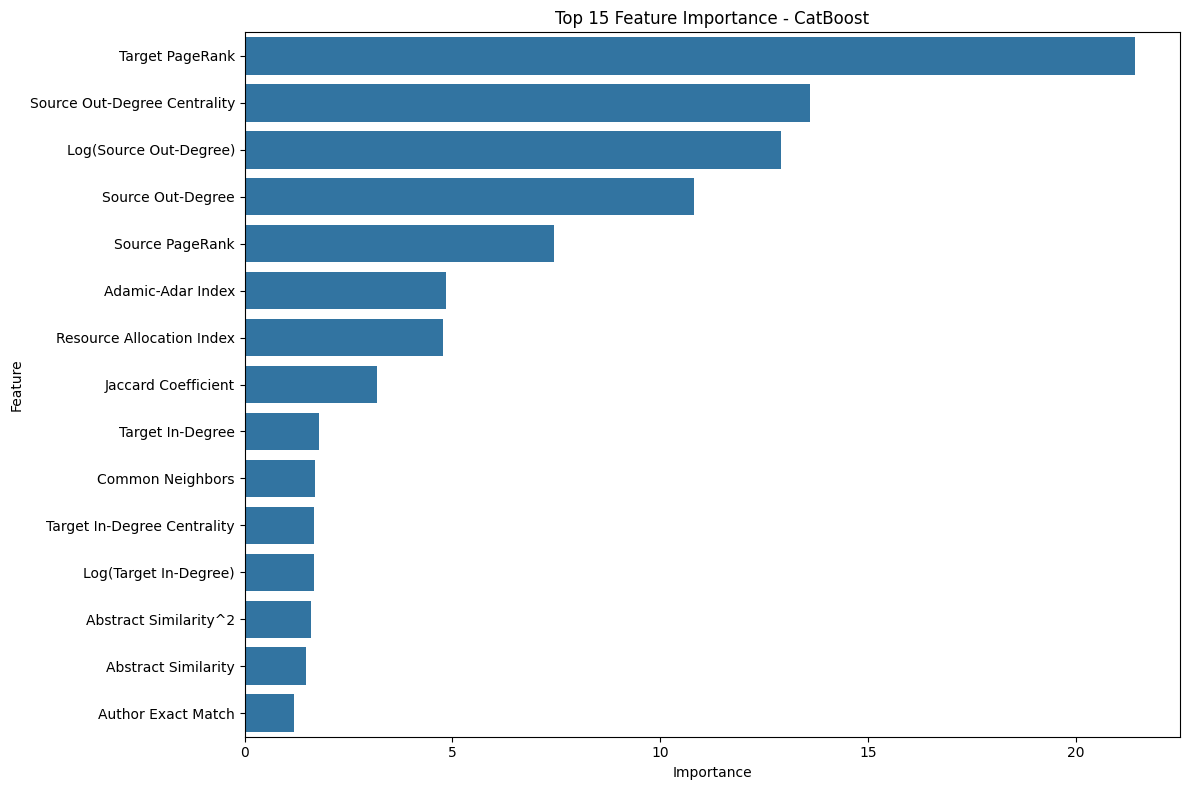

In [28]:
# Cell 10: Feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    # Create dynamic feature names based on the actual number of features
    num_features = len(best_model.feature_importances_)
    
    # Generate feature names dynamically based on the actual feature count
    feature_names = []
    
    # Extract feature names based on our feature generation logic in Cell 8
    feature_names.append("Abstract Similarity")
    feature_names.append("Abstract Similarity^2")
    
    # Author features
    feature_names.append("Author Overlap")
    feature_names.append("Author Exact Match")
    feature_names.append("Abstract Sim * Author Overlap")
    
    # Node features - source
    feature_names.append("Source In-Degree")
    feature_names.append("Source Out-Degree")
    feature_names.append("Source Total Degree")
    feature_names.append("Log(Source In-Degree)")
    feature_names.append("Log(Source Out-Degree)")
    feature_names.append("Source In-Degree Centrality")
    feature_names.append("Source Out-Degree Centrality")
    feature_names.append("Source PageRank")
    
    # Node features - target
    feature_names.append("Target In-Degree")
    feature_names.append("Target Out-Degree")
    feature_names.append("Target Total Degree")
    feature_names.append("Log(Target In-Degree)")
    feature_names.append("Log(Target Out-Degree)")
    feature_names.append("Target In-Degree Centrality")
    feature_names.append("Target Out-Degree Centrality")
    feature_names.append("Target PageRank")
    
    # Degree ratios and differences
    feature_names.append("Source/Target Degree Ratio")
    feature_names.append("Target/Source Degree Ratio")
    feature_names.append("Degree Difference")
    feature_names.append("Normalized Degree Difference")
    
    # Network features
    feature_names.append("Common Neighbors")
    feature_names.append("Log(Common Neighbors)")
    feature_names.append("Adamic-Adar Index")
    feature_names.append("Jaccard Coefficient")
    feature_names.append("Resource Allocation Index")
    feature_names.append("Preferential Attachment")
    feature_names.append("Log(Preferential Attachment)")
    feature_names.append("Citation Pattern Similarity")
    feature_names.append("Co-citation Similarity")
    
    # Combined features
    feature_names.append("PageRank Product")
    feature_names.append("Abstract Sim * Common Neighbors")
    feature_names.append("Abstract Sim * Adamic-Adar")
    feature_names.append("Author Overlap * Common Neighbors")
    feature_names.append("Normalized Preferential Attachment")
    
    # Path-based features
    feature_names.append("Inverse Shortest Path Length")
    
    # Direction-specific features
    feature_names.append("Successors Similarity")
    feature_names.append("Predecessors Similarity")
    
    # If the feature names are fewer than the actual features, add generic names
    while len(feature_names) < num_features:
        feature_names.append(f"Feature {len(feature_names)}")
    
    # If we have too many feature names, trim the list
    feature_names = feature_names[:num_features]
    
    # Create a DataFrame for feature importance
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance.head(20))  # Show top 20 features
    
    # Plot feature importance for top features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)  # Plot top 15 features
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

Σε αυτό το βήμα χρησιμοποιούμε το καλύτερο εκπαιδευμένο μοντέλο για να προβλέψουμε αν υπάρχει αναφορά (citation) μεταξύ ζευγών papers στο 

- Εξαγωγή χαρακτηριστικών για τα test ζεύγη
- Υπολογισμός πιθανότητας citation από το μοντέλο
- Δημιουργία αρχείου `submission.csv` για υποβολή
- Ανάλυση της κατανομής των προβλέψεων

1. Καλούμε τη συνάρτηση `extract_features(...)` για κάθε test pair, ώστε να δημιουργήσουμε το ίδιο σύνολο χαρακτηριστικών όπως και στο training set:



2. Πρόβλεψη πιθανοτήτων Citation

Χρησιμοποιείται η μέθοδος `predict_proba()` του εκπαιδευμένου μοντέλου για να προβλεφθεί η πιθανότητα αναφοράς.  
Παίρνουμε το δεύτερο στοιχείo `[:, 1]` που αντιστοιχεί στην πιθανότητα να υπάρχει citation.



3. Δημιουργία Αρχείου Υποβολής

Δημιουργείται αρχείο `submission.csv` που περιέχει:
- `ID`: Αύξων αριθμός κάθε ζεύγους
- `Label`: Πιθανότητα citation (τιμή μεταξύ 0 και 1)


Τι πετυχαίνουμε:
- Ένα **χρησιμοποιήσιμο αρχείο πρόβλεψης**
- Μία πρώτη **εικόνα της απόδοσης του μοντέλου** (μέσω των πιθανοτήτων)
- Προετοιμασία για **αξιολόγηση, testing ή παραγωγή**


Predicting on test data...
Processing 106692 node pairs...
Progress: 10.0% (10669/106692)
Progress: 20.0% (21338/106692)
Progress: 30.0% (32007/106692)
Progress: 40.0% (42676/106692)
Progress: 50.0% (53345/106692)
Progress: 60.0% (64014/106692)
Progress: 70.0% (74683/106692)
Progress: 80.0% (85352/106692)
Progress: 90.0% (96021/106692)
Progress: 100.0% (106690/106692)
Created 41 features per node pair
Prediction and submission completed in 14.28 seconds
Submission file created as 'submission_0609_1608.csv'

Prediction Statistics:
Min: 0.0000
Max: 1.0000
Mean: 0.4856
Std: 0.4535


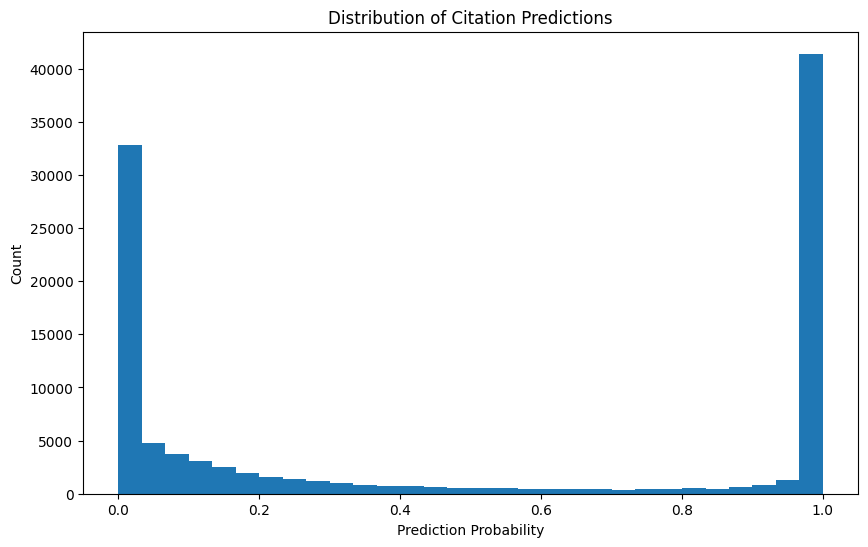

In [29]:
# Cell 11: Make predictions on test data 
print("Predicting on test data...")
start_time = time.time()

# Extract features for test data
X_test = extract_features(G, test_pairs, authors)

# Make predictions with the best model
test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'ID': range(len(test_pairs)),
    'Label': test_pred_proba
})

# Create a timestamp for the submission file
from datetime import datetime
timestamp = datetime.now().strftime("%m%d_%H%M")
submission_filename = f'submission_{timestamp}.csv'

submission.to_csv(submission_filename, index=False)
print(f"Prediction and submission completed in {time.time() - start_time:.2f} seconds")
print(f"Submission file created as '{submission_filename}'")

# Check prediction distribution
print("\nPrediction Statistics:")
print(f"Min: {np.min(test_pred_proba):.4f}")
print(f"Max: {np.max(test_pred_proba):.4f}")
print(f"Mean: {np.mean(test_pred_proba):.4f}")
print(f"Std: {np.std(test_pred_proba):.4f}")

# Visualize prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(test_pred_proba, bins=30)
plt.title('Distribution of Citation Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.savefig('prediction_distribution.png')
plt.show()